In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

In [2]:
#import data
creep_df = pd.read_csv('../PI_Data/PI_Ni_superalloys_dataset.csv')

# Log transform of creep rupture life, then convert data type to float32
creep_df['log_creep_life'] = np.log10(creep_df['Creep life'])
creep_df = creep_df.drop(['Creep life'], axis=1)
creep_df = creep_df.astype('float32')
creep_df

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature,log_creep_life
0,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1100.0,137.0,944.638367,3.026370
1,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796,3.009026
2,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796,2.969556
3,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677,2.957607
4,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655,2.939519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644,1.155336
148,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381,1.089905
149,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902,0.991226
150,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101,0.968483


In [3]:
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ni                152 non-null    float32
 1   Al                152 non-null    float32
 2   Co                152 non-null    float32
 3   Cr                152 non-null    float32
 4   Mo                152 non-null    float32
 5   Re                152 non-null    float32
 6   Ru                152 non-null    float32
 7   Ta                152 non-null    float32
 8   W                 152 non-null    float32
 9   Ti                152 non-null    float32
 10  Nb                152 non-null    float32
 11  T                 152 non-null    float32
 12  Stress            152 non-null    float32
 13  PI Creep Feature  152 non-null    float32
 14  log_creep_life    152 non-null    float32
dtypes: float32(15)
memory usage: 9.0 KB


In [4]:
creep_df.sort_values(by=['log_creep_life'], ascending=True, ignore_index=True, inplace=True)
creep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ni                152 non-null    float32
 1   Al                152 non-null    float32
 2   Co                152 non-null    float32
 3   Cr                152 non-null    float32
 4   Mo                152 non-null    float32
 5   Re                152 non-null    float32
 6   Ru                152 non-null    float32
 7   Ta                152 non-null    float32
 8   W                 152 non-null    float32
 9   Ti                152 non-null    float32
 10  Nb                152 non-null    float32
 11  T                 152 non-null    float32
 12  Stress            152 non-null    float32
 13  PI Creep Feature  152 non-null    float32
 14  log_creep_life    152 non-null    float32
dtypes: float32(15)
memory usage: 9.0 KB


In [5]:
# Extract features and targets
features = creep_df.iloc[:, 0:14]
targets = creep_df.iloc[:, 14]
features

,Ni,Al,Co,Cr,Mo,Re,Ru,Ta,W,Ti,Nb,T,Stress,PI Creep Feature
0,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,272.0,8.275208
1,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,220.0,10.204101
2,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,225.0,8.838902
3,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1070.0,280.0,11.414381
4,61.000000,5.60,9.0,4.3,2.0,2.00,0.0,7.50,8.0,0.0,0.5,1100.0,210.0,13.599644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,50.570000,5.55,16.5,2.0,2.0,5.95,3.0,8.25,6.0,0.0,0.0,982.0,248.0,820.808655
148,61.680000,6.00,9.0,3.5,1.5,4.00,0.0,8.00,6.0,0.2,0.0,1100.0,120.0,831.518677
149,59.299999,5.80,5.8,2.9,3.9,4.90,6.0,5.60,5.8,0.0,0.0,1000.0,245.0,952.328796
150,59.799999,5.60,5.6,4.6,2.4,6.40,5.0,5.60,5.0,0.0,0.0,1000.0,245.0,952.328796


In [6]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

class BNN(PyroModule):
    def __init__(self, in_dim=14, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

# Coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future

Run # 1 Fold # 1


Sample: 100%|██████████| 200/200 [06:21,  1.91s/it, step size=1.77e-03, acc. prob=0.836]


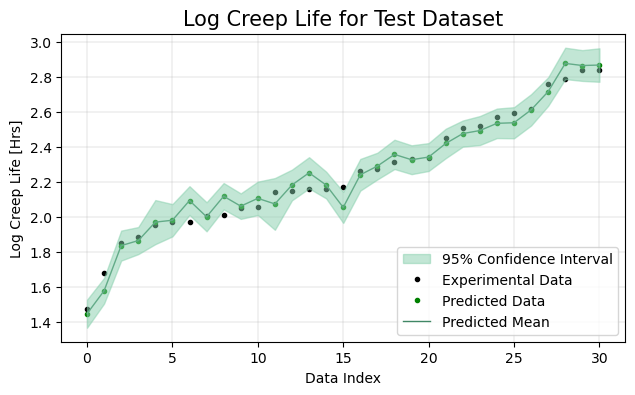

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9875849289613186
R2 score: 0.9741940330033878
RMSE: 0.053814247250556946
MAE: 0.041064247488975525
Coverage: 80.64516129032253
Interval Width: 0.16788959503173828
Composite Metric: 2.0939125260311924
********************
Run # 1 Fold # 2


Sample: 100%|██████████| 200/200 [06:05,  1.83s/it, step size=1.94e-03, acc. prob=0.889]


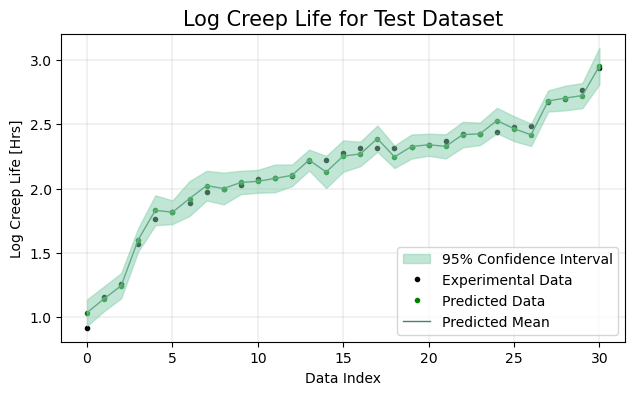

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9954334734571603
R2 score: 0.9902204058615854
RMSE: 0.04450851306319237
MAE: 0.031857214868068695
Coverage: 96.77419354838705
Interval Width: 0.19259381294250488
Composite Metric: 2.0238751495654825
********************
Run # 1 Fold # 3


Sample: 100%|██████████| 200/200 [06:12,  1.86s/it, step size=1.19e-03, acc. prob=0.951]


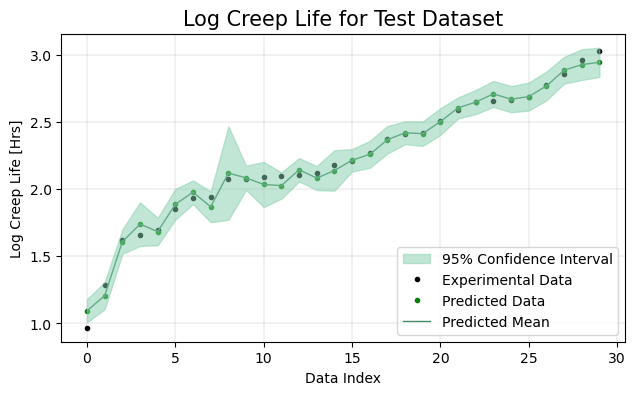

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9954376166849669
R2 score: 0.9906655791012628
RMSE: 0.04599621519446373
MAE: 0.0339052677154541
Coverage: 96.66666666666664
Interval Width: 0.1982729434967041
Composite Metric: 1.985888125182626
********************
Run # 1 Fold # 4


Sample: 100%|██████████| 200/200 [06:43,  2.02s/it, step size=1.42e-03, acc. prob=0.941]


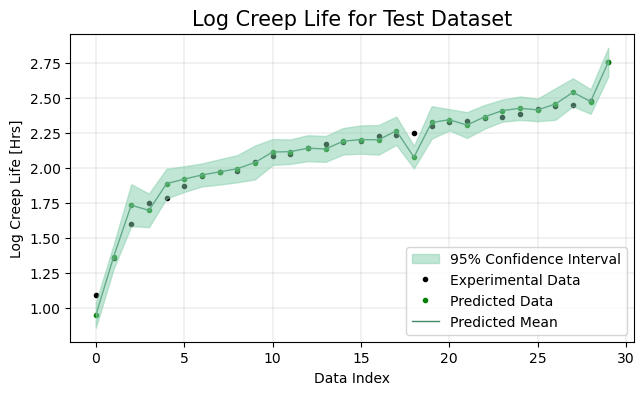

c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

Pearson CC: 0.9866736357024941
R2 score: 0.9709488320444069
RMSE: 0.05826009064912796
MAE: 0.03742868825793266
Coverage: 93.33333333333331
Interval Width: 0.1846768856048584
Composite Metric: 2.0537157028677067
********************
Run # 1 Fold # 5


Sample: 100%|██████████| 200/200 [06:53,  2.07s/it, step size=1.00e-03, acc. prob=0.968]


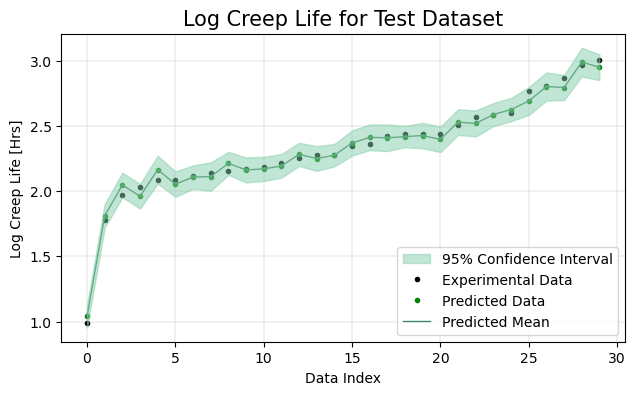

Pearson CC: 0.9948372150376263
R2 score: 0.9883069827825836
RMSE: 0.0417182631790638
MAE: 0.03416575863957405
Coverage: 99.99999999999997
Interval Width: 0.1916341781616211
Composite Metric: 2.054568957366019
********************


c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\longz\anaconda3\envs\pytorchcpu\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype

In [7]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            # define DNN
            model = BNN(hid_dim=10, n_hid_layers=3, prior_scale=1)
            nuts_kernel = NUTS(model, jit_compile=False)
            mcmc = MCMC(nuts_kernel, num_samples=100)
            mcmc.run(torch.Tensor(x_train), torch.Tensor(y_train.to_numpy()))

            # evaluate the model on test data
            predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
            preds = predictive(torch.Tensor(x_test))

            y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
            y_std = preds['obs'].T.detach().numpy().std(axis=1)

            ## Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Creep Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Creep Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])
            plt.show()

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            print(20*'*')

In [8]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.987585,0.974194,0.053814,0.041064
1,0.995433,0.990220,0.044509,0.031857
2,0.995438,0.990666,0.045996,0.033905
3,0.986674,0.970949,0.058260,0.037429
4,0.994837,0.988307,0.041718,0.034166


In [9]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)


# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.991993,0.003988,0.982867,0.008506,0.048859,0.006181,0.035684,0.003228


In [10]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,80.645161,0.167890,2.093913
1,96.774194,0.192594,2.023875
2,96.666667,0.198273,1.985888
3,93.333333,0.184677,2.053716
4,100.000000,0.191634,2.054569


In [11]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,93.483871,6.756796,0.187013,0.010492,2.042392,0.035962
